In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_path = r"D:\Prayag Files\TIET\Extras\hackathons\analog\Brain_Tumor_Detection"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
class_names = class_names[1:]

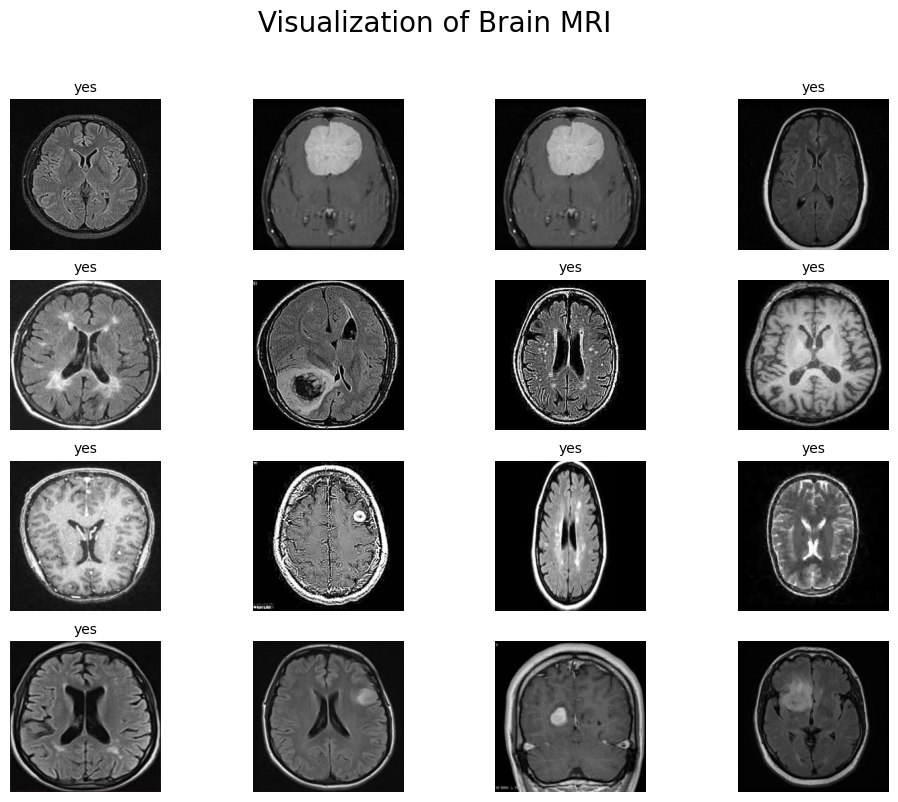

In [3]:
fig = plt.figure(figsize=(12, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(dataset), size=[1]).item()
    img, label = dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.suptitle("Visualization of Brain MRI", fontsize=20)
    if label < len(class_names):
        plt.title(class_names[label], fontsize=10)
    plt.axis(False);

In [4]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
    
def load_dataset_from_directory(directory):
    image_paths = []
    labels = []

    class_names = ['no', 'yes']
    class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if img_path.endswith(('.png', '.jpg', 'JPG', '.jpeg')):  # Let's filter image file extensions
                image_paths.append(img_path)
                labels.append(class_to_idx[class_name])

    return image_paths, labels

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_paths, labels = load_dataset_from_directory(dataset_path)
dataset = CustomDataset(image_paths, labels, transform)

# Train-validation and dataset split
train_size = int(0.7 * len(dataset))  # %80 Train
val_test_size = len(dataset) - train_size  # %20 Validation-Test
train_dataset, val_test_dataset = random_split(dataset, [train_size, val_test_size])

val_size = int(0.6 * len(val_test_dataset)) # Val
test_size = len(val_test_dataset) - val_size # Test
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

# Load dataset with Dataloader with batch size
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [6]:
for i in torch.arange(253):
    print(image_paths[i], "\t", labels[i])

D:\Prayag Files\TIET\Extras\hackathons\analog\Brain_Tumor_Detection\no\no0.jpg 	 0
D:\Prayag Files\TIET\Extras\hackathons\analog\Brain_Tumor_Detection\no\no1.jpg 	 0
D:\Prayag Files\TIET\Extras\hackathons\analog\Brain_Tumor_Detection\no\no10.jpg 	 0
D:\Prayag Files\TIET\Extras\hackathons\analog\Brain_Tumor_Detection\no\no100.jpg 	 0
D:\Prayag Files\TIET\Extras\hackathons\analog\Brain_Tumor_Detection\no\no1000.jpg 	 0
D:\Prayag Files\TIET\Extras\hackathons\analog\Brain_Tumor_Detection\no\no1001.jpg 	 0
D:\Prayag Files\TIET\Extras\hackathons\analog\Brain_Tumor_Detection\no\no1002.jpg 	 0
D:\Prayag Files\TIET\Extras\hackathons\analog\Brain_Tumor_Detection\no\no1003.jpg 	 0
D:\Prayag Files\TIET\Extras\hackathons\analog\Brain_Tumor_Detection\no\no1004.jpg 	 0
D:\Prayag Files\TIET\Extras\hackathons\analog\Brain_Tumor_Detection\no\no1005.jpg 	 0
D:\Prayag Files\TIET\Extras\hackathons\analog\Brain_Tumor_Detection\no\no1006.jpg 	 0
D:\Prayag Files\TIET\Extras\hackathons\analog\Brain_Tumor_Detec

In [7]:
# Check dataset dimensions
print(f"Total data: {len(dataset)}")
print(f"Train data dimension: {len(train_dataset)}")
print(f"Val data dimension: {len(val_dataset)}")
print(f"Test data dimension: {len(test_dataset)}")

Total data: 3000
Train data dimension: 2100
Val data dimension: 540
Test data dimension: 360


In [8]:
try:
    # If multiple GPUs are available, use them
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_gpus = torch.cuda.device_count()
    print(f"Using {num_gpus} GPUs for training." if num_gpus > 1 else f"Using {torch.cuda.get_device_name()} for training." if torch.cuda.is_available() else "Using CPU for training.")
except:
    print("No GPU found. Using CPU.")
    device = torch.device("cpu")

Using CPU for training.


In [9]:
num_classes = len(class_names)
resnet152_model = models.resnet152(pretrained=True)
resnet152_model.fc = nn.Linear(resnet152_model.fc.in_features, num_classes).to(device)

In [10]:
resnet152_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
if num_gpus > 1:
    resnet152_model = nn.DataParallel(resnet152_model).to(device)

In [12]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for batch_inputs, batch_labels in train_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
    average_loss = total_loss / len(train_loader)
    accuracy = correct / total * 100
    return average_loss, accuracy

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_inputs, batch_labels in val_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
    average_loss = total_loss / len(val_loader)
    accuracy = correct / total * 100
    return accuracy, average_loss

In [ ]:
import torch

# Define criterion, optimizer and early stopping
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet152_model.parameters(), lr=1e-4, weight_decay=1e-3)

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    print(f'Starting Epoch {epoch + 1}/{num_epochs}')
    
    train_loss, train_accuracy = train(resnet152_model, train_loader, criterion, optimizer)
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    
    val_accuracy, val_loss = validate(resnet152_model, val_loader, criterion)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

print('Training was completed')


Starting Epoch 1/25
